# Recipe Recommendation Engine

## Introduction

This notebook implements the core recipe recommendation logic. It utilizes the cleaned and pre-processed data generated by the `Adding Data And Cleaning.ipynb` and intermediate files generated by `Recipe_Recommender_files.ipynb` notebook.

The key steps include:
1. Importing necessary libraries and setting up the environment (including SpaCy model loading).
2. Defining various helper functions for text processing, topic modeling analysis, keyword generation, and the main search algorithm.
3. Loading the pre-processed recipe data, tags, and potentially pre-computed topic models.
4. Configuring parameters for the recommendation model (e.g., weights for different text fields).
5. Vectorizing relevant text fields using TF-IDF.
6. Implementing and demonstrating the recipe search functionality based on user queries.

## 1. Libraries and Setup

Importing libraries required for NLP, data manipulation, machine learning, and visualization. Also includes downloading necessary NLTK data and loading SpaCy models.

**Note:** This notebook attempts to install `en_core_web_md` and `en_core_web_lg` but may encounter errors (as seen in initial runs). It falls back to using `en_core_web_sm`, which might affect the performance of NLP tasks requiring richer word vectors.

In [ ]:
!pip install en_core_web_md
!pip install en_core_web_lg

ERROR: Could not find a version that satisfies the requirement en_core_web_md (from versions: none)
ERROR: No matching distribution found for en_core_web_md
ERROR: Could not find a version that satisfies the requirement en_core_web_lg (from versions: none)
ERROR: No matching distribution found for en_core_web_lg


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Now coxantinue with your Python code
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp
import tabulate
from itertools import repeat
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve, recall_score, f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA, NMF
import spacy

import string
import re
import numpy as np
from functools import reduce

nlp = spacy.load('en_core_web_sm') # Load English tokenizer, tagger, parser, NER and word vectors

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## 2. Define Helper Functions

This section defines various functions used throughout the notebook, categorized as follows:

* **Text Processing:** Functions for cleaning and tokenizing/lemmatizing text data (`clean_text`, `text_tokenizer`, `text_tokenizer_mp`).
* **Topic Model Analysis:** Functions to explore documents and words associated with topics (`docs_by_tops`, `words_by_tops`).
* **Keyword/Tag Generation:** Functions implementing logic to extract keywords or tags from recipes, potentially using POS tagging and graph-based methods like PageRank (`generate_adjacency`, `generate_wordranks`, `generate_tag_list`, `generate_tags`, `generate_filter_kws`).
* **Search & Ranking:** Functions supporting the recipe search mechanism, including query weighting, score calculation, and result printing (`qweight_array`, `ranked_query`, `overall_scores`, `print_recipes`, `Search_Recipes`).

In [ ]:

# Function to clean the text documents
def clean_text(documents):
    cleaned_text = []
    for doc in documents:
        # Remove punctuation from the document
        doc = doc.translate(str.maketrans('', '', string.punctuation))
        # Remove digits from the document
        doc = re.sub(r'\d+', '', doc)
        # Replace newline characters with a space
        doc = doc.replace('\n',' ')
        # Strip leading and trailing whitespaces
        doc = doc.strip()
        # Replace multiple whitespaces with a single whitespace
        doc = re.sub(' +', ' ', doc)
        cleaned_text.append(doc)
    return cleaned_text

# Function to tokenize documents, lemmatize words, and remove stop words
def text_tokenizer(documents):
    tokenized_documents = []
    for doc in documents:
        # Tokenize the document, lemmatize each token, and remove stop words
        # 'nlp' must be a preloaded spacy language model object with loaded stop words
        tok_doc = ' '.join([token.lemma_ for token in nlp(doc) if not token.is_stop])
        tokenized_documents.append(tok_doc)
    return tokenized_documents

# Parallel version of the text tokenizer function for individual documents
def text_tokenizer_mp(doc):
    # Tokenize the document, lemmatize each token, and remove stop words
    # Similar to 'text_tokenizer' but designed for single document input
    print("thread ..")
    tok_doc = ' '.join([token.lemma_ for token in nlp(doc) if not token.is_stop])
    return tok_doc

# Function to explore topics in documents based on topic modeling results
def docs_by_tops(top_mat, topic_range = (0,0), doc_range = (0,2)):
    for i in range(topic_range[0], topic_range[1]):
        # Extract topic scores for the current topic
        topic_scores = pd.Series(top_mat[:,i])
        # Get indices of documents with the highest scores for this topic
        doc_index = topic_scores.sort_values(ascending = False)[doc_range[0]:doc_range[1]].index
        for j, index in enumerate(doc_index, doc_range[0]):
            # Print topic, document number, topic score, and the document text
            print('Topic #{}'.format(i),
                  '\nDocument #{}'.format(j),
                  '\nTopic Score: {}\n\n'.format(topic_scores[index]),
                  text_series[index], '\n\n')

# Function to find the best words representing each topic using cosine similarity
def words_by_tops(tfidf_mat, top_mat, topic_range=(0,0), n_words=10):
    # Multiply TF-IDF matrix by the topic matrix to get topic-word scores
    topic_word_scores = tfidf_mat.T * top_mat
    for i in range(topic_range[0],topic_range[1]):
        # Extract word scores for the current topic
        word_scores = pd.Series(topic_word_scores[:,i])
        # Get indices of words with the highest scores for this topic
        word_index = word_scores.sort_values(ascending = False)[:n_words].index
        print('\nTopic #{}'.format(i))
        for index in word_index:
            # Print the word and its score
            print(word_series[index],'\t\t', word_scores[index])




# Generate adjacency matrix from a list of keywords and parsed texts
def generate_adjacency(kw_filts, parsed_texts, N_neighbor_window):
    adjacency = pd.DataFrame(0, index=kw_filts, columns=kw_filts)
    for i, word in enumerate(parsed_texts):
        if str(word) in kw_filts:
            end = min(len(parsed_texts), i + N_neighbor_window + 1)
            window_words = [str(parsed_texts[j]) for j in range(i+1, end) if str(parsed_texts[j]) in kw_filts]
            for neighbor in window_words:
                adjacency.at[str(word), neighbor] += 1
    return adjacency

# Generate word ranks using the PageRank algorithm
def generate_wordranks(adjacency):
    nx_words = nx.from_pandas_adjacency(adjacency)
    ranks = nx.pagerank(nx_words, alpha=0.85, tol=0.00000001)
    return ranks

# Select top N words based on their PageRank scores
def generate_tag_list(ranks, N_top_words):
    ranked = sorted(((ranks[node], node) for node in ranks), reverse=True)
    return [node for _, node in ranked[:N_top_words]]

# Combine all steps to generate tags for a set of documents
def generate_tags(topic_document_scores, root_text_data, N_neighbor_window, N_top_words, nlp, recipe_stopwords):
    kw_filts, parsed_texts = generate_filter_kws(root_text_data, nlp, recipe_stopwords)
    adjacency = generate_adjacency(kw_filts, parsed_texts, N_neighbor_window)
    ranks = generate_wordranks(adjacency)
    kw_list = generate_tag_list(ranks, N_top_words)
    return kw_list

# Placeholder for a function that filters keywords based on POS tagging and stopwords
def generate_filter_kws(text_list, nlp, recipe_stopwords):
    #parsed_texts = nlp(' '.join(text_list))
    parsed_texts = list(nlp.pipe(text_list, batch_size=1000))
    kw_filts = set([str(word) for word in parsed_texts if word.pos_ in ('NOUN', 'ADJ', 'VERB') and word.lemma_ not in recipe_stopwords])
    return list(kw_filts), parsed_texts

def topic_docs_4kwsummary(topic_document_scores, root_text_data, N_top_docs):
    '''Selects top documents within each topic for keyword summary'''
    return root_text_data[:N_top_docs]

def generate_kw_index(topic_document_scores, N_docs_categorized):
    '''Generates indices for top documents within each topic'''
    return pd.Series(topic_document_scores).sort_values(ascending=False)[:N_docs_categorized].index

def qweight_array(query_length, qw_array = [1]):
    '''Returns descending weights for ranked query ingredients'''
    if query_length > 1:
        to_split = qw_array.pop()
        split = to_split/2
        qw_array.extend([split, split])
        return qweight_array(query_length - 1, qw_array)
    else:
        return np.array(qw_array)

# Searching Recipes
def ranked_query(query):
    '''Ranking query ingredients'''
    query = [[q] for q in query]
    q_vecs = [vectorizer.transform(q) for q in query]
    qw_array = qweight_array(len(query),[1])
    q_weighted_vecs = q_vecs * qw_array
    q_final_vector = reduce(np.add,q_weighted_vecs)
    return q_final_vector

def overall_scores(query_vector):
    '''Calculating query similarity scores'''
    final_scores = title_tfidf*query_vector.T*w_title
    final_scores += text_tfidf*query_vector.T*w_text
    final_scores += tags_tfidf*query_vector.T*w_categories
    return final_scores

def print_recipes(index, query, recipe_range):
    '''Printing recipes based on similarity ranks'''
    print('Search Query: {}\n'.format(query))
    for i, index in enumerate(index, recipe_range[0]):
        print('Recipe Rank: {}\t'.format(i+1),recipes.loc[index, 'title'],'\n')
        print('Type: {}\t'.format(recipes.loc[index, 'type']))
        print('Ingredient Count: {}\n'.format(recipes.loc[index, 'ingredient_count']))
        print('Ingredients:\n{}\n '.format(recipes.loc[index, 'ingredient_text']))
        print('Instructions:\n{}\n'.format(recipes.loc[index, 'instructions']))

def Search_Recipes(query, query_ranked=False, recipe_range=(0,3)):
    '''Master Recipe Search Function'''
    if query_ranked == True:
        q_vector = ranked_query(query)
    else:
        q_vector = vectorizer.transform([' '.join(query)])
    recipe_scores = overall_scores(q_vector)
    sorted_index = pd.Series(recipe_scores.toarray().T[0]).sort_values(ascending = False)[recipe_range[0]:recipe_range[1]].index
    return print_recipes(sorted_index, query, recipe_range)

def text_cleaner(i, n, document):
    for j in range(i, n):
        # Tokenize the document, lemmatize each token, and remove stop words
        # 'nlp' must be a preloaded spacy language model object with loaded stop words

        document[j] = ' '.join([token.lemma_ for token in nlp(document[j]) if not token.is_stop])
    return

## 3. Load Processed Data

Loading the pre-processed recipe data, including recipe details, generated tags, tokenized text, and potentially pre-computed topic model matrices (LDA/NMF).

**Note:** This section relies on Google Colab and accessing specific paths within Google Drive (`/content/drive/MyDrive/Colab Notebooks/`). Ensure the Drive is mounted and the paths are correct if running in a different environment.

In [ ]:
from google.colab import drive
from google.colab.data_table import DataTable
drive.mount('/content/drive')

dataframes = []
for i in range(15):
    filename = f"/content/drive/My Drive/Colab Notebooks/recipes_tagged_{i}.csv"
    df = pd.read_csv(filename)
    dataframes.append(df)

recipes_tagged = pd.concat(dataframes, ignore_index=True)
recipes_tagged['tags'] = recipes_tagged['tag_list'].apply(lambda x: ''.join(map(str, x)))
recipes = recipes_tagged.copy()

cleaned_text = pd.read_csv("/content/drive/My Drive/Colab Notebooks/tokenized_text.csv")

all_text = recipes['Combined']
nlp = spacy.load('en_core_web_sm')


## 4. Configuration and Parameters

Defining key parameters and configurations for the modeling and recommendation process:
* Topic modeling parameters (`N_topics`, `N_top_docs`, etc.)
* Weights for combining similarity scores across different fields (`w_title`, `w_text`, `w_categories`).
* Custom list of recipe-specific stop words (`recipe_stopwords`).

In [ ]:

N_topics = 50
N_top_docs = 200
N_top_words = 25
N_docs_categorized = 2000
N_neighbor_window = 4

w_title = 0.4
w_text = 0.4
w_categories = 0.2
w_array = np.array([w_title, w_text, w_categories])

recipe_stopwords = ['cup', 'cups', 'ingredient', 'ingredients', 'teaspoon', 'tablespoon', 'oven', 'teaspoon', 't', 'tsp.', 'tablespoon', 'T', 'tbsp.', 'fluid ounce', 'fl oz', 'cup', 'c', 'pint', 'pt', 'quart', 'qt', 'gallon', 'gal', 'milliliter', 'ml', 'liter', 'l', 'ounce', 'oz', 'pound', 'lb', 'gram', 'g', 'kilogram', 'kg', 'pinch', 'dash', 'handful', 'stick', 'clove', 'slice', 'piece', 'bunch', 'dozen', 'microgram', 'mcg', 'milligram', 'mg', 'cup', 'c', 'spoonful', 'drop', 'dr', 'peck', 'bushel', 'score', 'gross', 'stone', 'fresh', 'oil', 'a', 'red', 'bunch', 'medium', 'peeled', 'diced', 'sliced', 'chopped', 'finely', 'cups', 'teaspoons', 'tablespoons', 'ounce', 'ounces', 'packages', 'package', 'pound', 'pounds', 'canned', 'drained', 'rinsed', 'minced', 'jar', 'bottles', 'bottle', 'ground', 'whole', 'halves', 'leaf', 'leaves', 'shredded', 'cubed', 'frozen', 'thawed', 'squeezed', 'dry', 'crushed', 'grated', 'pinch', 'dashes', 'dash', 'packed', 'slice', 'slices', 'lightly', 'beaten', 'optional', 'for', 'garnish', 'cut', 'into', 'pieces', 'and', 'more', 'as', 'needed','room', 'side','beat','overbeat','liner','fill','thicken','preheat','bowl','mom','remove', 'blend', 'molasse', 'extract', 'rack','preheat', 'inch', 'food','tube', 'turn','thick', 'pour', 'wire', 'round', 'paper','combine', 'rest', 'speed', 'Stir','grate', 'light','soften', 'clump', 'paperline', 'drain', 'foil', 'press','flute', 'spatula', 'spray','diameter','time', 'minute','F','measure','boiling','Mix', 'dish', 'tin', 'boil','pick','C', 'divide', 'desire', 'sift', 'tip', 'container', 'halve', 'win', 'form', 'follow', 'mixture', 'center', 'water', 'insert', 'scoop', 'transfer', 'incorporate', 'stir','wrap']

vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(1,1))
text_tfidf = vectorizer.fit_transform(all_text)
tfidf_words = vectorizer.get_feature_names_out()
text_lda = np.load('/content/drive/My Drive/Colab Notebooks/text_lda(1).npy')
text_nmf = np.load('/content/drive/My Drive/Colab Notebooks/text_nmf(1).npy')

cleaned_text = cleaned_text.rename(columns={'Unnamed: 0': 'index', '0': 'text'})
text_series = pd.Series(all_text)
word_series = pd.Series(tfidf_words)

text_index = pd.Series(text_nmf[:,1]).sort_values(ascending=False)[:100].index
text_4summary_df = cleaned_text.loc[text_index, 'text']
text_4summary = pd.Series(text_4summary_df)

parsed_texts = nlp(' '.join(text_4summary))
kw_filts = set([str(word) for word in parsed_texts if (word.pos_==('NOUN' or 'ADJ' or 'VERB')) and str(word) not in recipe_stopwords])
kw_filts_list = list(set(list(kw_filts)))

topic_transformed_matrix = text_nmf
root_text_data = cleaned_text

words_by_tops(text_tfidf, text_lda, (0,3), 10)
words_by_tops(text_tfidf, text_nmf, (0,3), 10)

title_tfidf = vectorizer.transform(recipes_tagged['title'])
tags_tfidf = vectorizer.transform(recipes_tagged['tags'])

query = ['cinnamon', 'cream', 'banana']
Search_Recipes(query, query_ranked=True, recipe_range=(0,3))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Topic #0
the 		 88.77093853600725
and 		 73.44324282427529
to 		 42.20017862314039
in 		 34.12266598958028
with 		 27.73486526725079
cup 		 25.84249874785939
oil 		 24.170009132571277
until 		 23.619214305120032
salt 		 22.500716644893732
pepper 		 22.132197697956418

Topic #1
the 		 1220.486992634395
and 		 794.1079514112678
dough 		 708.9925566764213
to 		 569.5849202820438
in 		 438.40534433050493
sugar 		 411.876207303992
with 		 402.0202559930178
of 		 391.39479162958645
butter 		 369.4175261471494
flour 		 354.3737453980322

Topic #2
the 		 65.63881496970646
and 		 53.896346782583485
to 		 31.20291713597448
in 		 25.82177314656198
with 		 21.094323400928502
cup 		 19.48446607549083
until 		 17.654756681260537
of 		 16.81782214508701
salt 		 14.95672462702292
pepper 		 14.802802445134898

Topic #0
the 		 28.4949035961409
and 		 26.72567617328268
tomatoe

In [ ]:
query =["I want to eat scallion, papaya, crab"]
Search_Recipes(query, query_ranked=True, recipe_range=(0,2))

Search Query: ['I want to eat scallion, papaya, crab']

Recipe Rank: 1	 Salad with Papaya Dressing  

Type: veg	
Ingredient Count: 11

Ingredients:
['1 firm-ripe papaya (10 to 12 oz), halved lengthwise', '1 tablespoon finely grated peeled fresh ginger', '1 tablespoon minced onion', '1 tablespoon chopped fresh tarragon', '1 teaspoon minced garlic', '1 teaspoon dry mustard', '2 tablespoons fresh lemon juice', '1/2 teaspoon salt', '1/8 teaspoon black pepper', '1/2 cup vegetable oil', 'Lettuce leaves']
 
Instructions:
Scrape seeds from papaya and coarsely chop enough seeds to measure 2 tablespoons. Discard remaining seeds, then peel papaya halves and slice. Press ginger in a fine-mesh sieve or a garlic press into a small bowl to extract juice (about 1 teaspoon), discarding pulp. Whisk in chopped papaya seeds, onion, tarragon, garlic, mustard, lemon juice, salt, and pepper and add oil in a slow stream, whisking until emulsified. Divide lettuce and papaya slices among 4 plates and drizzle wi

In [ ]:
query =["lemongrass, beef, sour"]
Search_Recipes(query, query_ranked=True, recipe_range=(0,3))

Search Query: ['lemongrass, beef, sour']

Recipe Rank: 1	 Fresh Lemongrass Syrup 

Type: veg	
Ingredient Count: 3

Ingredients:
['2 stalks fresh lemongrass, coarsely chopped', '2 cups water', '1 cup sugar']
 
Instructions:
Place the lemongrass, water, and sugar in a saucepan and bring to a boil. Reduce heat, and simmer, partially covered, for 15 minutes. Strain the mixture and cool. Cover and refrigerate for up to a week.
Copyright (c) 2004 Television Food Network, G.P., All Rights Reserved.

Recipe Rank: 2	 Lemongrass-Lime Leaf  

Type: veg	
Ingredient Count: 6

Ingredients:
['1/4 cup lemon zest (from 6 lemons)', '1/4 cup lime zest (from 8 limes)', '20 kaffir lime leaves', '2 stalks lemongrass, roughly chopped', '3/4 cup Simple Syrup , divided', '6 cups soda water, divided']
 
Instructions:
Combine citrus zest, lime leaves, lemongrass, and 2 cups water in a small saucepan. Bring to a boil, reduce heat, and simmer for 5 minutes. Strain lemongrass mixture into a jar and chill. Fill a 12

In [ ]:
query =["Romatic dinner with soup of spinach"]
Search_Recipes(query, query_ranked=True, recipe_range=(0,3))

Search Query: ['Romatic dinner with soup of spinach']

Recipe Rank: 1	 Cream of Spinach Soup 

Type: veg	
Ingredient Count: 8

Ingredients:
['1 1/2 cups water', '3 cubes chicken bouillon', '1 (10 ounce) package frozen chopped spinach', '3 tablespoons butter', '1/4 cup all-purpose flour', '3 cups milk', '1 tablespoon dried minced onion', 'salt and pepper to taste']
 
Instructions:
In a medium saucepan, combine water, bouillon, and spinach. Bring to a boil, and cook until spinach is tender.
Melt butter in a large saucepan over medium heat. Stir in flour, and cook for 2 minutes. Gradually whisk in milk. Season with minced onion, salt, and pepper. Cook, stirring constantly, until thickened. Stir in spinach mixture.


Recipe Rank: 2	 Tomato and Spinach Soup 

Type: veg	
Ingredient Count: 8

Ingredients:
['2 tablespoons evoo, extra-virgin olive oil, 2 turns of the pan', '1 large shallot, finely chopped', '2 cloves garlic, chopped', '1 (28-ounce) can diced tomatoes in juice, drained', '1 can 

In [ ]:
query =["I want to eat chicken fried rice indian"]
Search_Recipes(query, query_ranked=True, recipe_range=(0,3))

Search Query: ['I want to eat chicken fried rice indian']

Recipe Rank: 1	 Indian Fried Chicken 

Type: veg	
Ingredient Count: 12

Ingredients:
['3/4 cup plain 2% Greek yogurt', '1 clove garlic, grated', '2 1/2 teaspoons curry powder', 'Kosher salt and freshly ground black pepper', '1/4 teaspoon cayenne pepper', '8 small skinless, boneless chicken thighs (about 2 pounds)', '4 small sweet potatoes (5 to 6 ounces each)', '5 cups crispy rice cereal', 'Peanut or vegetable oil, for frying', '1/2 cup ketchup', '1 tablespoon steak sauce', '2 tablespoons chopped fresh cilantro, plus more for topping']
 
Instructions:
Preheat the oven to 450 degrees F. Mix 1/4 cup yogurt, the garlic, 2 teaspoons curry powder, 1 teaspoon salt, a few grinds of black pepper and the cayenne in a large bowl. Add the chicken and toss to coat; set aside.
Pierce the sweet potatoes all over with a fork. Bake on a baking sheet until tender, about 25 minutes. Meanwhile, pulse the cereal in a food processor until finely gr

In [ ]:
query =["I want to make ramen in 2 hours"]
Search_Recipes(query, query_ranked=True, recipe_range=(0,5))

Search Query: ['I want to make ramen in 2 hours']

Recipe Rank: 1	 Ramen Pizza 

Type: veg	
Ingredient Count: 5

Ingredients:
['2 packages ramen noodles', '1 cup tomato sauce', '1 cup grated mozzarella', '2 tablespoons Parmesan', '16 pepperoni slices']
 
Instructions:
Preheat the oven to 400 degrees F.
Separate the ramen noodle blocks into 2 thin ramen squares each (4 thin ramen squares total). Pour 1/4 cup of tomato sauce on each ramen square and top with 1/4 cup mozzarella, 1 1/2 teaspoons Parmesan and 4 slices of pepperoni.
Transfer the ramen pizzas to a baking sheet and bake until the cheese has melted and the edges are a dark golden brown, about 10 minutes.

Recipe Rank: 2	 Top Ramen 

Type: veg	
Ingredient Count: 6

Ingredients:
['2 cups water', '1 (3 ounce) package instant ramen noodles (exclude seasoning packet)', '2 tablespoons garlic powder', '2 tablespoons onion powder', '2 tablespoons ground ginger', 'salt and ground black pepper to taste']
 
Instructions:
Bring 2 cups wate

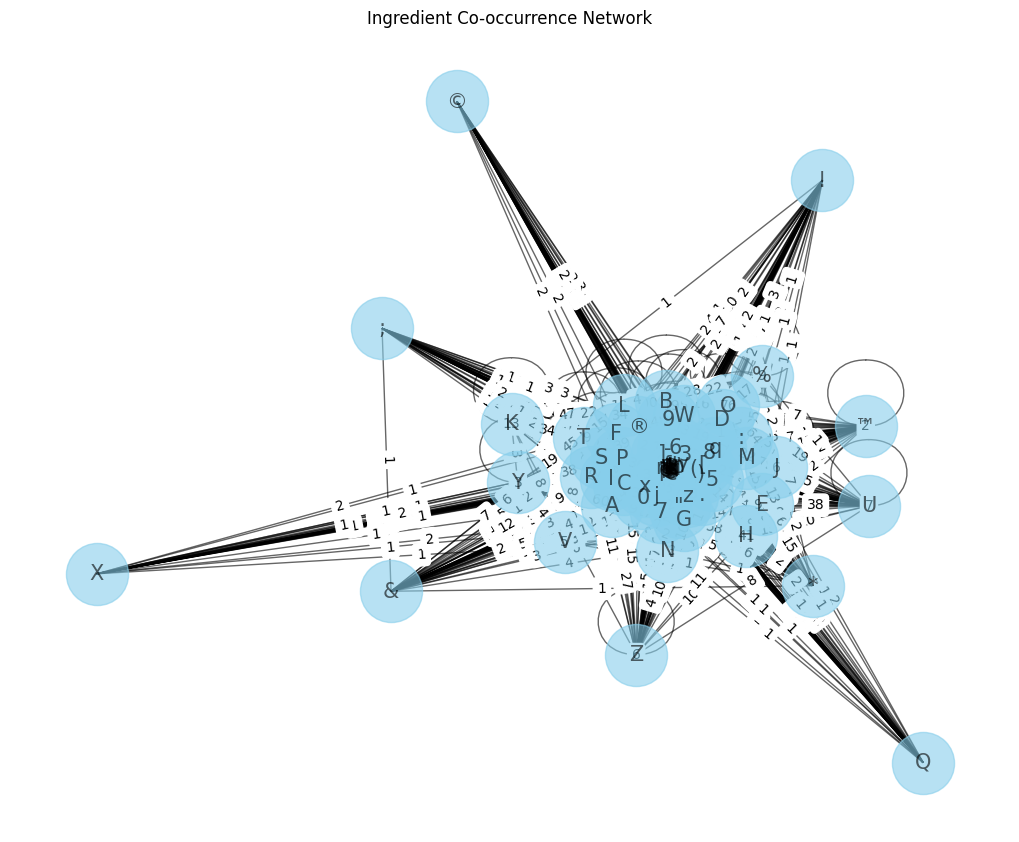

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations


df = recipes.copy()
df = df[:10000]

# Step 2: Create Co-occurrence Matrix
co_occurrence = {}
for ingredients in df['ingredients']:
    for ingredient_pair in combinations(ingredients, 2):
        # Sort the tuple to avoid duplicate entries (e.g., (a, b) vs. (b, a))
        ingredient_pair = tuple(sorted(ingredient_pair))
        if ingredient_pair not in co_occurrence:
            co_occurrence[ingredient_pair] = 1
        else:
            co_occurrence[ingredient_pair] += 1

# Step 3: Create Network Graph
G = nx.Graph()
for pair, weight in co_occurrence.items():
    G.add_edge(pair[0], pair[1], weight=weight)

# Step 4: Visualization
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5)  # k regulates the distance between nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='k', linewidths=1, font_size=15, alpha=0.6)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('Ingredient Co-occurrence Network')
plt.axis('off')
plt.show()


In [ ]:
text_tfidf

In [ ]:
cleaned_text